In [1]:
# load dataset data/test.csv and data/train.csv

import pandas as pd

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print(train.shape, test.shape)

train.head()

(120000, 2) (7600, 2)


,text,label
0,wall st bear claw back black reuters reuters s...,2
1,carlyle look toward commercial aerospace reute...,2
2,oil economy cloud stock outlook reuters reuter...,2
3,iraq halt oil export main southern pipeline re...,2
4,oil price soar alltime record posing new menac...,2


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

# create a TF-IDF vectorizer object for english
tfidf = TfidfVectorizer(stop_words='english')

# fit the object with the training data
tfidf.fit(train.text)

# transform the training data
train_tfidf = tfidf.transform(train.text)

# transform the test data
test_tfidf = tfidf.transform(test.text)

print(train_tfidf.shape, test_tfidf.shape)

(120000, 77346) (7600, 77346)


In [5]:
from sklearn.decomposition import TruncatedSVD

# Number of topics
n_topics = 4

# Apply NMF for topic modeling on the vectorized data
lsa = TruncatedSVD(n_components=n_topics, random_state=42).fit(train_tfidf)

# transform the training data
train_lsa = lsa.transform(train_tfidf)

# transform the test data
test_lsa = lsa.transform(test_tfidf)

print(train_lsa.shape, test_lsa.shape)

(120000, 4) (7600, 4)


In [6]:
import numpy as np

# Get the dominant topic for each 
dominant_topics = np.argmax(train_lsa, axis=1)

# distribution of dominant topics
import pandas as pd
pd.Series(dominant_topics).value_counts()

0    95408
3    14509
2     6878
1     3205
Name: count, dtype: int64

In [7]:
# print the top 15 words for each topic
feature_names = tfidf.get_feature_names_out()

for topic_idx, topic in enumerate(lsa.components_):
    print(f"Topic #{topic_idx}:")
    # print the top words with their probabilities
    for i in topic.argsort()[:-15 - 1:-1]:
        print(f"{feature_names[i]}: {topic[i]}")
    print()

Topic #0:
new: 0.21645265114480636
reuters: 0.21002192857207205
oil: 0.206947246935083
ap: 0.19020694343938407
said: 0.18643964218646455
price: 0.16511481250607168
stock: 0.13699021344331203
year: 0.1210238237044615
company: 0.11780909052932646
york: 0.11259167155460811
iraq: 0.09746024833102805
world: 0.09670996971633056
microsoft: 0.09090102801960581
wednesday: 0.09083056909239977
monday: 0.09067748191905141

Topic #1:
oil: 0.4923268093345998
price: 0.3578268959432568
stock: 0.2455583609307019
crude: 0.1418069427531634
barrel: 0.11226692945500324
higher: 0.09500427426606033
high: 0.08979431577771886
supply: 0.08522378642098008
reuters: 0.08366263137808301
profit: 0.08299620995954653
york: 0.08204342709704214
dollar: 0.07078955754450855
percent: 0.06739796728928373
record: 0.06592106520297167
rise: 0.06584168492812412

Topic #2:
oil: 0.2546823170226232
iraq: 0.2530269334917382
killed: 0.14398186723515852
baghdad: 0.14056939022415726
iraqi: 0.13903932258423568
price: 0.1336793582251197

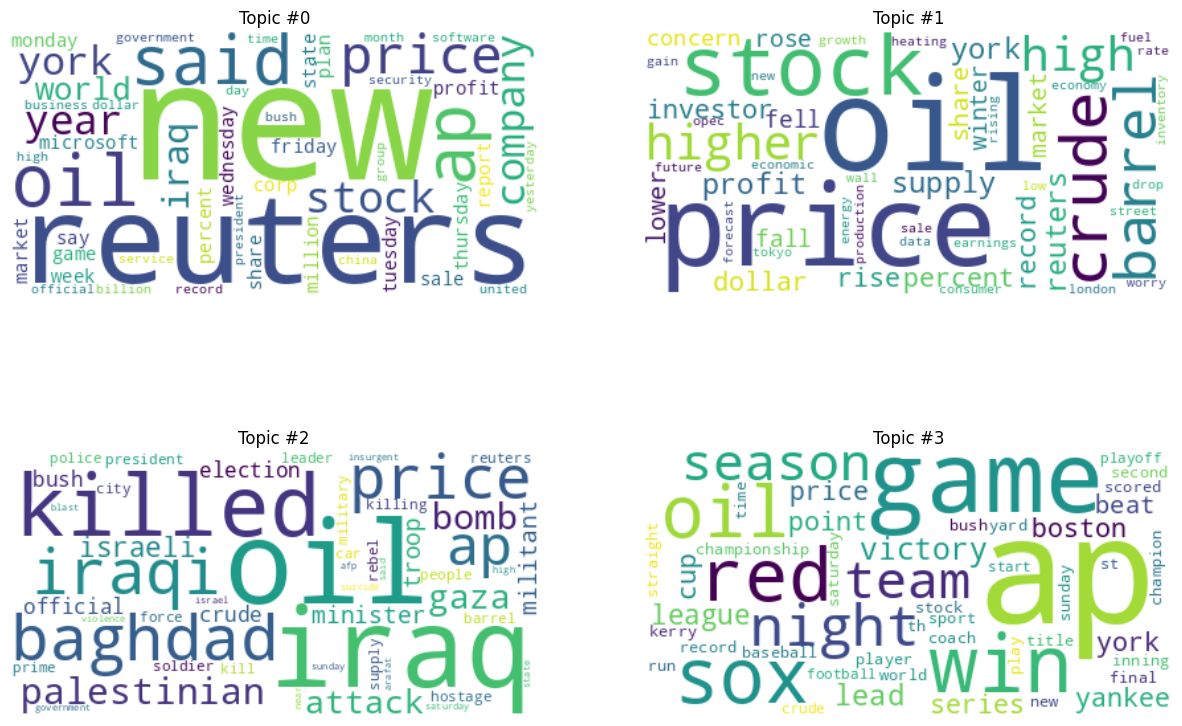

In [8]:
# use wordclouds to visualize each topic
from wordcloud import WordCloud
from matplotlib import pyplot as plt

# Creating a word cloud for each topic
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

# no need to visualize the top 15, just visualize ALL the words
for topic_idx, topic in enumerate(lsa.components_):
    # create a dataframe with words and their probabilities
    df = pd.DataFrame([feature_names, topic]).T
    df.columns = ['words', 'probabilities']
    # create a dictionary with words and their probabilities
    words = dict(zip(df.words, df.probabilities))
    # create the wordcloud
    wc = WordCloud(background_color='white', max_words=50)
    wc.generate_from_frequencies(words)
    # plot the wordcloud
    axs[topic_idx].imshow(wc, interpolation='bilinear')
    axs[topic_idx].set_title(f'Topic #{topic_idx}')
    axs[topic_idx].axis('off')
    
plt.show()

In [9]:
import pandas as pd

n_labels = 4

# Initialize a DataFrame to store label counts per topic
label_counts_per_topic = pd.DataFrame(0, index=range(n_topics), columns=range(n_labels))

# Loop over the training data, train is a df with columns ['text', 'label']
for i in range(len(train)):
    topic = dominant_topics[i]
    label = train.label[i]
    label_counts_per_topic.loc[topic, label] += 1

label_percentages_per_topic = label_counts_per_topic.divide(label_counts_per_topic.sum(axis=1), axis=0)

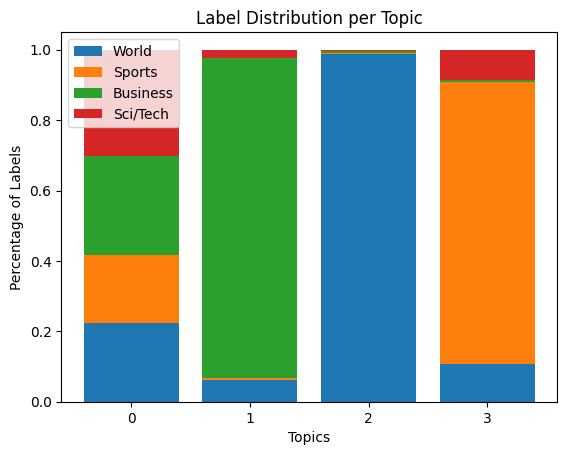

In [10]:
import matplotlib.pyplot as plt
import numpy as np

label_names = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

topic_label_count = np.zeros((n_topics, n_labels))

# Count the labels for each topic
for doc_idx, topic in enumerate(dominant_topics):
    label = train.label[doc_idx]
    topic_label_count[topic, label] += 1

# Convert counts to percentages
topic_label_percentage = topic_label_count / topic_label_count.sum(axis=1, keepdims=True)

# Plotting
fig, ax = plt.subplots()
for label in range(n_labels):
    # Compute bottom position for each bar
    bottom = np.sum(topic_label_percentage[:, :label], axis=1)
    ax.bar(range(n_topics), topic_label_percentage[:, label], bottom=bottom, label=label_names[label])

ax.set_xlabel('Topics')
ax.set_ylabel('Percentage of Labels')
ax.set_title('Label Distribution per Topic')
ax.set_xticks(range(n_topics))
ax.legend()
plt.show()

In [11]:
# let's do the same thing for the test data
# Get the dominant topic for each 
dominant_topics = np.argmax(test_lsa, axis=1)

pd.Series(dominant_topics).value_counts()

0    6052
3     947
2     427
1     174
Name: count, dtype: int64

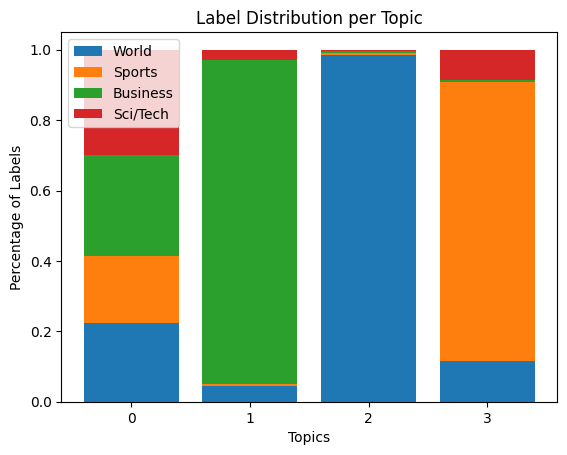

In [12]:
# Initialize a DataFrame to store label counts per topic
label_counts_per_topic = pd.DataFrame(0, index=range(n_topics), columns=range(n_labels))

# Loop over the training data, train is a df with columns ['text', 'label']
for i in range(len(test)):
    topic = dominant_topics[i]
    label = test.label[i]
    label_counts_per_topic.loc[topic, label] += 1

label_percentages_per_topic = label_counts_per_topic.divide(label_counts_per_topic.sum(axis=1), axis=0)

topic_label_count = np.zeros((n_topics, n_labels))

# Count the labels for each topic
for doc_idx, topic in enumerate(dominant_topics):
    label = test.label[doc_idx]
    topic_label_count[topic, label] += 1

# Convert counts to percentages
topic_label_percentage = topic_label_count / topic_label_count.sum(axis=1, keepdims=True)

# Plotting
fig, ax = plt.subplots()
for label in range(n_labels):
    # Compute bottom position for each bar
    bottom = np.sum(topic_label_percentage[:, :label], axis=1)
    ax.bar(range(n_topics), topic_label_percentage[:, label], bottom=bottom, label=label_names[label])

ax.set_xlabel('Topics')
ax.set_ylabel('Percentage of Labels')
ax.set_title('Label Distribution per Topic')
ax.set_xticks(range(n_topics))
ax.legend()
plt.show()